In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    optimizers,
    utils,
    callbacks,
    metrics,
    losses,
    activations,
)

2025-11-12 15:26:28.584338: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762961188.759114      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762961188.809854      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# Parameter
IMAGE_SIZE = 64
BATCH_SIZE = 64
DATASET_REPETITIONS = 5
LOAD_MODEL = False

NOISE_EMBEDDING_SIZE = 32
PLOT_DIFFUSION_STEPS = 20

# optimization
EMA = 0.999
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 50

In [3]:
# Load data
train_data= utils.image_dataset_from_directory(
    "/kaggle/input/phool-fool/flower_data/flower_data",
    labels=None,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=None,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 8189 files.


I0000 00:00:1762961215.207531      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [4]:
# Preprocess
def preprocess(img):
    img= tf.cast(img, "float32")/255.0
    return img

In [5]:
train= train_data.map(lambda x:preprocess(x))
train=train.repeat(DATASET_REPETITIONS)
train=train.batch(BATCH_SIZE, drop_remainder=True)

In [6]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()

In [7]:
train_sample = sample_batch(train)
display(train_sample)

array([[[[2.33700976e-01, 2.25857839e-01, 3.58398445e-02],
         [2.56495088e-01, 2.50980407e-01, 4.39950973e-02],
         [2.75245100e-01, 2.56495088e-01, 5.88235296e-02],
         ...,
         [6.16025209e-01, 5.38451672e-01, 2.11368337e-01],
         [6.16973042e-01, 5.22855401e-01, 1.77757353e-01],
         [5.33444405e-01, 4.18081731e-01, 1.14583336e-01]],

        [[1.99080884e-01, 1.87316179e-01, 1.90908387e-02],
         [2.40686268e-01, 2.32843131e-01, 4.15441170e-02],
         [2.61213243e-01, 2.55085796e-01, 5.42279407e-02],
         ...,
         [6.61188364e-01, 5.99301100e-01, 2.65967757e-01],
         [6.89399481e-01, 6.13541663e-01, 2.63664216e-01],
         [5.36948502e-01, 4.37990189e-01, 1.27022058e-01]],

        [[2.18933821e-01, 2.07169116e-01, 3.06985285e-02],
         [2.36544505e-01, 2.28701368e-01, 3.62994038e-02],
         [2.20281869e-01, 2.16360301e-01, 2.81249993e-02],
         ...,
         [5.74754894e-01, 4.96200979e-01, 1.47139251e-01],
         [

In [8]:
# Diffusion Schedules -> Linear
# To make sure in early stages noising process,, we take smaller steps than in later ones
def linear_diffusion_schedule(diffusion_times):
    min_rate=0.0001
    max_rate=0.02
    betas= min_rate+diffusion_times * (max_rate - min_rate)
    alphas= 1 - betas
    alpha_bar= tf.math.cumprod(alphas)
    signal_rates= tf.sqrt(1-alpha_bar)
    noise_rates = tf.sqrt(1 - alpha_bar)
    return noise_rates, signal_rates

In [9]:
def cosine_diffusion_schedulers(diffusion_times):
    signal_rates= tf.cos(diffusion_times * math.pi/2)
    noise_rates= tf.sin(diffusion_times * math.pi/2)
    return noise_rates, signal_rates

In [10]:
def offset_cosine_diffusion_schedulers(diffusion_times):
    min_signal_rate= 0.02
    max_signal_rate= 0.95
    start_angle= tf.acos(max_signal_rate)
    end_angle= tf.acos(min_signal_rate)

    diffusion_angle= start_angle+diffusion_times * (end_angle- start_angle)
    signal_rate= tf.cos(diffusion_angle)
    noise_rate= tf.sin(diffusion_angle)

    return noise_rate, signal_rate

In [11]:
T = 1000
diffusion_times= tf.convert_to_tensor([x/T for x in range(T)])
linear_nr, linear_sr= linear_diffusion_schedule(diffusion_times)
cosine_nr, cosine_sr= cosine_diffusion_schedulers(diffusion_times)
offset_cosine_nr, offset_cosine_sr = offset_cosine_diffusion_schedulers(diffusion_times)

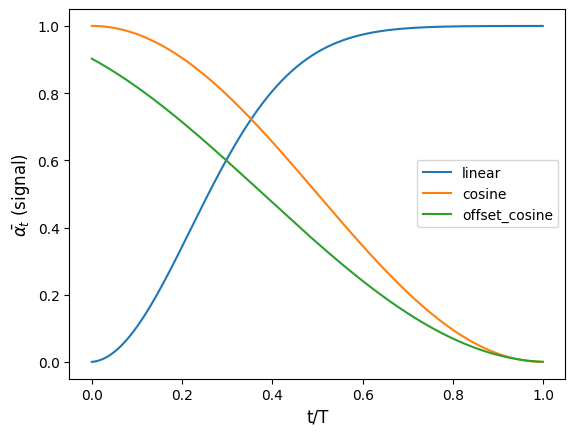

In [12]:
plt.plot(
    diffusion_times, linear_sr**2, linewidth=1.5, label="linear"
)
plt.plot(
    diffusion_times, cosine_sr**2, linewidth=1.5, label="cosine"
)
plt.plot(
    diffusion_times,
    offset_cosine_sr**2,
    linewidth=1.5,
    label="offset_cosine",
)

plt.xlabel("t/T", fontsize=12)
plt.ylabel(r"$\bar{\alpha_t}$ (signal)", fontsize=12)
plt.legend()
plt.show()

In [13]:
# Sinusoidal embeddings
def sinusoidal_embedding(x):
    freq= tf.exp(tf.linspace(tf.math.log(1.0), tf.math.log(1000.0), NOISE_EMBEDDING_SIZE//2,))
    angular_speeds= 2.0 * math.pi * freq
    embedding= tf.concat(
        [tf.sin(angular_speeds*x), tf.cos(angular_speeds*x)], axis=3
    )
    return embedding

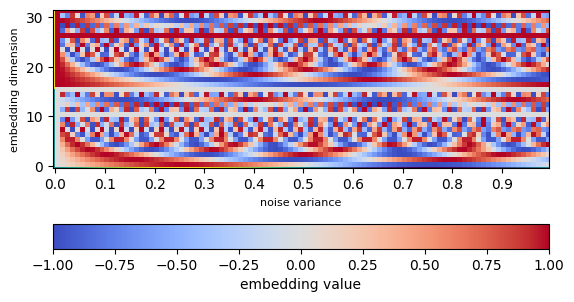

In [14]:
embedding_list = []
for y in np.arange(0, 1, 0.01):
    embedding_list.append(sinusoidal_embedding(np.array([[[[y]]]]))[0][0][0])
embedding_array = np.array(np.transpose(embedding_list))
fig, ax = plt.subplots()
ax.set_xticks(
    np.arange(0, 100, 10), labels=np.round(np.arange(0.0, 1.0, 0.1), 1)
)
ax.set_ylabel("embedding dimension", fontsize=8)
ax.set_xlabel("noise variance", fontsize=8)
plt.pcolor(embedding_array, cmap="coolwarm")
plt.colorbar(orientation="horizontal", label="embedding value")
ax.imshow(embedding_array, interpolation="nearest", origin="lower")
plt.show()

In [15]:
def Residual_block(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply

In [16]:
def Down_block(width, block_depth):
    def apply(x):
        x, skips=x
        for _ in range(block_depth):
            x=Residual_block(width)(x)
            skips.append(x)
        x=layers.AveragePooling2D(pool_size=2)(x)
        return x
    return apply

In [17]:
def Up_block(width, block_depth):
    def apply(x):
        x,skips=x
        x=layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x=Residual_block(width)(x)
        return x
    return apply

In [18]:
noisy_images = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = layers.Conv2D(32, kernel_size=1)(noisy_images)

noise_variances = layers.Input(shape=(1, 1, 1))
noise_embedding = layers.Lambda(sinusoidal_embedding)(noise_variances)
noise_embedding = layers.UpSampling2D(size=IMAGE_SIZE, interpolation="nearest")(
    noise_embedding
)

x = layers.Concatenate()([x, noise_embedding])

skips = []

x = Down_block(32, block_depth=2)([x, skips])
x = Down_block(64, block_depth=2)([x, skips])
x = Down_block(96, block_depth=2)([x, skips])

x = Residual_block(128)(x)
x = Residual_block(128)(x)

x = Up_block(96, block_depth=2)([x, skips])
x = Up_block(64, block_depth=2)([x, skips])
x = Up_block(32, block_depth=2)([x, skips])

x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

unet = models.Model([noisy_images, noise_variances], x, name="unet")

In [19]:
unet.summary()

Model: "unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1, 1, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 1, 32)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        128 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ lambda[0][0]      │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d[0][0],     │
│ (Concatenate)       │ 64)               │            │ up_sampling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,464 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      2,080 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ conv2d_3[0][0],   │
│                     │ 32)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │         64 │ add[0][0]         │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_4[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64,    │          0 │ conv2d_5[0][0],   │
│                     │ 32)               │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 32, 32,    │          0 │ add_1[0][0]       │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ average_pooling2… │
│ (BatchNormalizatio… │ 32)               │            │                 

 Total params: 1,953,507 (7.45 MB)

 Trainable params: 1,950,627 (7.44 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [20]:
class Diffusion_model(models.Model):
    def __init__(self):
        super().__init__()

        self.normalizer=layers.Normalization()
        self.network=unet
        # Instead of cloning, build EMA network separately
        noisy_images_ema = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
        noise_variances_ema = layers.Input(shape=(1, 1, 1))
        x_ema = layers.Conv2D(32, kernel_size=1)(noisy_images_ema)
        noise_embedding_ema = layers.Lambda(sinusoidal_embedding)(noise_variances_ema)
        noise_embedding_ema = layers.UpSampling2D(size=IMAGE_SIZE, interpolation="nearest")(noise_embedding_ema)
        x_ema = layers.Concatenate()([x_ema, noise_embedding_ema])
        skips_ema = []
        x_ema = Down_block(32, block_depth=2)([x_ema, skips_ema])
        x_ema = Down_block(64, block_depth=2)([x_ema, skips_ema])
        x_ema = Down_block(96, block_depth=2)([x_ema, skips_ema])
        x_ema = Residual_block(128)(x_ema)
        x_ema = Residual_block(128)(x_ema)
        x_ema = Up_block(96, block_depth=2)([x_ema, skips_ema])
        x_ema = Up_block(64, block_depth=2)([x_ema, skips_ema])
        x_ema = Up_block(32, block_depth=2)([x_ema, skips_ema])
        x_ema = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x_ema)
        self.ema_network = models.Model([noisy_images_ema, noise_variances_ema], x_ema, name="unet_ema")
        self.diffusion_schedule= offset_cosine_diffusion_schedulers

    def call(self, inputs, training=False):
        noisy_img, noise_variance = inputs
        noise_rate, signal_rate = self.diffusion_schedule(noise_variance)
        pred_noise, pred_img = self.denoise(noisy_img, noise_rate, signal_rate, training=training)
        return pred_img

    def compile(self, **kwargs):
        super().compile(**kwargs)
        self.noise_loss_tracker=metrics.Mean(name="n_loss")

    @property
    def metrics(self):
        return [self.noise_loss_tracker]

    def denormalize(self, img):
        imgs= self.normalizer.mean+img*self.normalizer.variance**0.5
        return tf.clip_by_value(imgs, 0.0, 1.0)

    def denoise(self, noisy_img, noise_rate, signal_rate, training):
        if training:
            network=self.network
        else:
            network=self.ema_network
        pred_noise= network(
            [noisy_img, noise_rate**2], training=training
        )
        pred_img= (noisy_img-noise_rate*pred_noise)/signal_rate
        return pred_noise, pred_img

    def reverse_diffusion(self, initial_noise, diffusion_step):
        num_img= initial_noise.shape[0]
        step_size=1.0/diffusion_step
        current_img= initial_noise
        for steps in range(diffusion_step):
            diffusion_times= tf.ones((num_img, 1,1,1)) - steps * step_size
            noise_rate, signal_rate= self.diffusion_schedule(diffusion_times)
            pred_noise, pred_img= self.denoise(
                current_img, noise_rate, signal_rate, training=False
            )
            next_diffusion_time= diffusion_times-step_size
            next_noise_rate, next_signal_rate= self.diffusion_schedule(next_diffusion_time)
            current_img=(next_signal_rate*pred_img+next_noise_rate*pred_noise)
        return pred_img

    def generate(self, num_images, diffusion_steps, initial_noise=None):
        if initial_noise is None:
            initial_noise= tf.random.normal(
                shape=(num_images, IMAGE_SIZE, IMAGE_SIZE,3)
            )
        generated_img= self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_img= self.denormalize(generated_img)
        return generated_img

    def train_step(self, img):
        img= self.normalizer(img, training=True)
        noise= tf.random.normal(shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))
        diffusion_time= tf.random.uniform(
            shape=(BATCH_SIZE, 1,1,1), minval=0.0, maxval=1.0
        )
        noise_rate, signal_rate= self.diffusion_schedule(diffusion_time)
        noisy_images = signal_rate * img + noise_rate * noise

        with tf.GradientTape() as tape:
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rate, signal_rate, training=True
            )

            noise_loss = self.loss(noise, pred_noises)  

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(
            zip(gradients, self.network.trainable_weights)
        )

        self.noise_loss_tracker.update_state(noise_loss)

        for weight, ema_weight in zip(
            self.network.weights, self.ema_network.weights
        ):
            ema_weight.assign(EMA * ema_weight + (1 - EMA) * weight)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))
        diffusion_times = tf.random.uniform(
            shape=(BATCH_SIZE, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )
        noise_loss = self.loss(noises, pred_noises)
        self.noise_loss_tracker.update_state(noise_loss)

        return {m.name: m.result() for m in self.metrics}

In [21]:
ddm= Diffusion_model()
ddm.normalizer.adapt(train)

In [22]:
if LOAD_MODEL:
    ddm.built=True
    ddm.load_weights()

In [23]:
ddm.compile(
    optimizer=optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    ),
    loss=losses.MeanAbsoluteError(),
)

In [24]:
sample_batch_data = next(iter(train))
sample_noise_variance = tf.ones((BATCH_SIZE, 1, 1, 1))
ddm([sample_batch_data, sample_noise_variance])

I0000 00:00:1762961262.597718      48 cuda_dnn.cc:529] Loaded cuDNN version 90300


<tf.Tensor: shape=(64, 64, 64, 3), dtype=float32, numpy=
array([[[[1.49020243e+01, 1.76471329e+01, 1.78432121e+01],
         [1.49020243e+01, 1.76471329e+01, 1.78432121e+01],
         [1.49816799e+01, 1.77267914e+01, 1.79228706e+01],
         ...,
         [2.14454994e+01, 2.04651031e+01, 2.14822636e+01],
         [2.05362854e+01, 1.96355476e+01, 2.01808929e+01],
         [2.66169930e+01, 2.58326759e+01, 2.60287552e+01]],

        [[1.45098658e+01, 1.72549744e+01, 1.74510536e+01],
         [1.50642586e+01, 1.78093681e+01, 1.80054474e+01],
         [1.47059450e+01, 1.74510536e+01, 1.76471329e+01],
         ...,
         [2.00881195e+01, 1.93466949e+01, 1.86726723e+01],
         [3.22739487e+01, 3.14896297e+01, 3.12077637e+01],
         [2.38944321e+01, 2.31101151e+01, 2.33061943e+01]],

        [[1.50981035e+01, 1.72549744e+01, 1.76471329e+01],
         [1.58423529e+01, 1.79992237e+01, 1.83913822e+01],
         [1.56924686e+01, 1.78493404e+01, 1.82414989e+01],
         ...,
         [2.

In [25]:
import matplotlib.pyplot as plt
import os
from tensorflow.keras import callbacks

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, save_dir="./output"):
        super().__init__()
        self.num_img = num_img
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generate(
            num_images=self.num_img,
            diffusion_steps=PLOT_DIFFUSION_STEPS,
        ).numpy()

        for i, img in enumerate(generated_images):
            plt.imshow((img * 255).astype("uint8"))
            plt.axis("off")
            filepath = os.path.join(self.save_dir, f"generated_img_epoch{epoch:03d}_{i:02d}.png")
            plt.savefig(filepath, bbox_inches="tight", pad_inches=0)
            plt.close()

        print(f"✅ Saved {self.num_img} generated images to {self.save_dir}/ at epoch {epoch}")

In [27]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.weights.h5",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

In [29]:
image_generator_callback = ImageGenerator(num_img=10)

his = ddm.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        image_generator_callback,
    ],
)

Epoch 1/50


I0000 00:00:1762961359.695135     110 service.cc:148] XLA service 0x7beaf81d1770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762961359.695926     110 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/639 ━━━━━━━━━━━━━━━━━━━━ 58s 91ms/step - n_loss: 0.7976   

I0000 00:00:1762961377.165900     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - n_loss: 0.2969✅ Saved 10 generated images to ./output/ at epoch 0
639/639 ━━━━━━━━━━━━━━━━━━━━ 89s 91ms/step - n_loss: 0.2968
Epoch 2/50
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - n_loss: 0.1979✅ Saved 10 generated images to ./output/ at epoch 1
639/639 ━━━━━━━━━━━━━━━━━━━━ 57s 89ms/step - n_loss: 0.1979
Epoch 3/50
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - n_loss: 0.1922✅ Saved 10 generated images to ./output/ at epoch 2
639/639 ━━━━━━━━━━━━━━━━━━━━ 57s 89ms/step - n_loss: 0.1922
Epoch 4/50
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - n_loss: 0.1863✅ Saved 10 generated images to ./output/ at epoch 3
639/639 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - n_loss: 0.1863
Epoch 5/50
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - n_loss: 0.1838✅ Saved 10 generated images to ./output/ at epoch 4
639/639 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - n_loss: 0.1838
Epoch 6/50
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - n_loss: 0.1830✅ Saved 10 generated images to ./outp

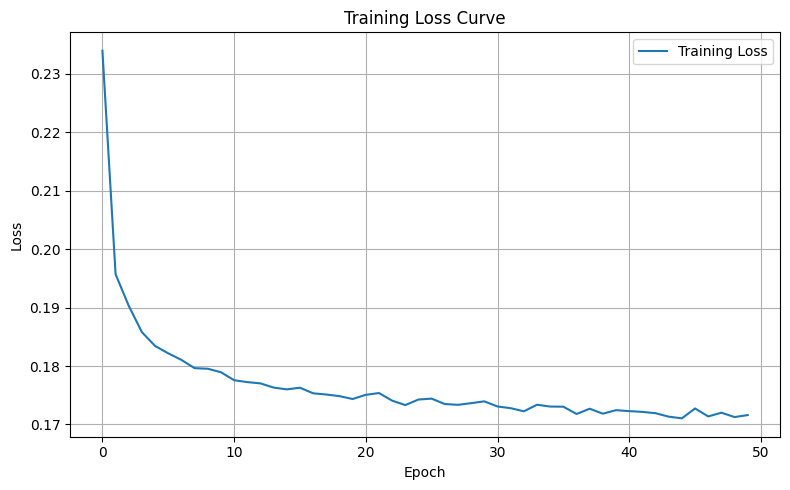

In [30]:
import matplotlib.pyplot as plt

history = his.history

plt.figure(figsize=(8,5))
plt.plot(history["n_loss"], label="Training Loss")

# If validation loss exists, plot it too
if "val_loss" in history:
    plt.plot(history["val_loss"], label="Validation Loss")

plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

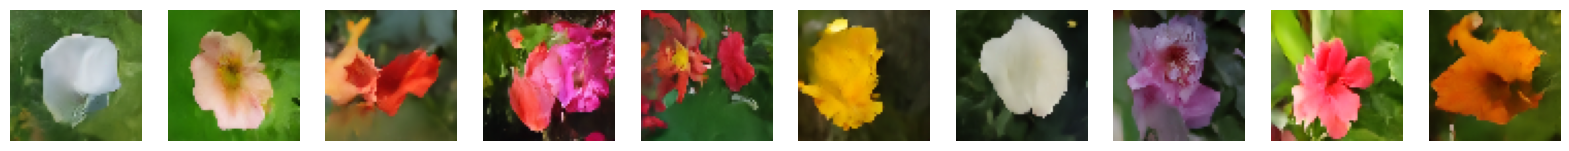

In [32]:
generated_images = ddm.generate(num_images=10, diffusion_steps=20).numpy()
display(generated_images)

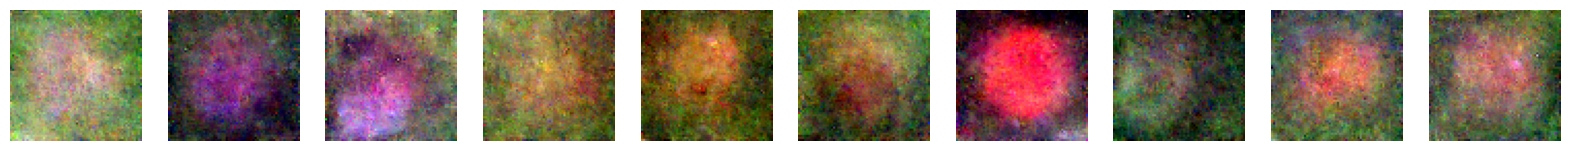

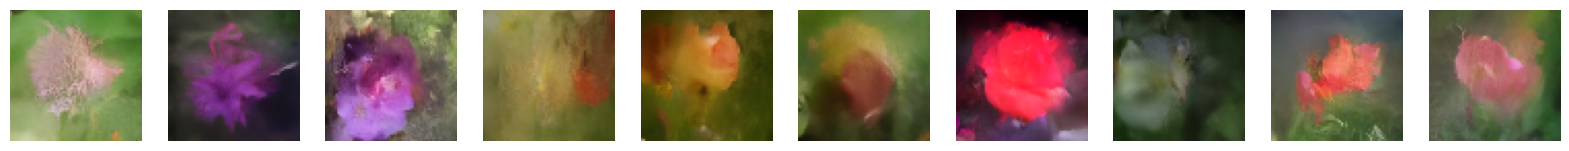

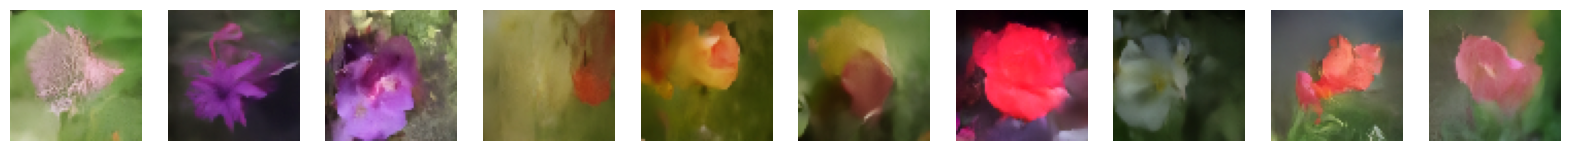

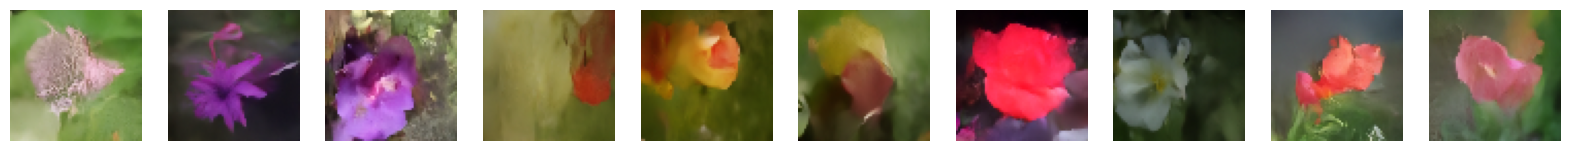

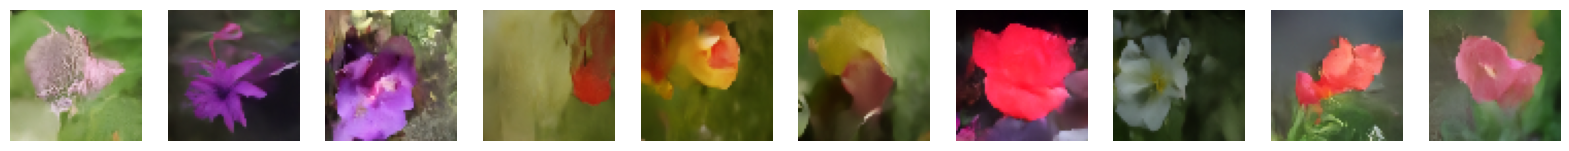

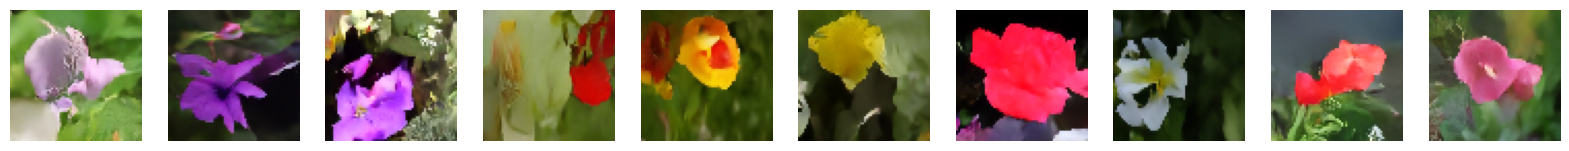

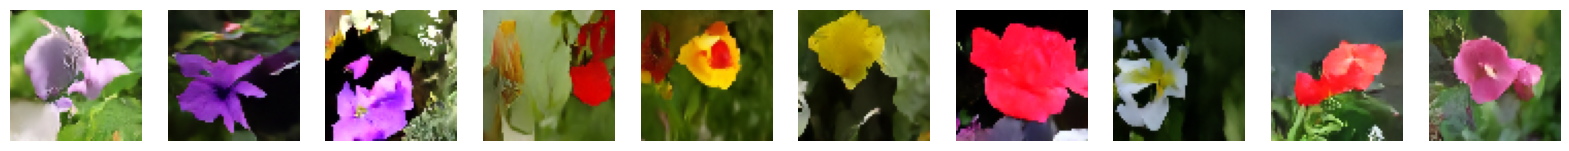

In [33]:
for diffusion_steps in list(np.arange(1, 6, 1)) + [20] + [100]:
    tf.random.set_seed(42)
    generated_images = ddm.generate(
        num_images=10,
        diffusion_steps=diffusion_steps,
    ).numpy()
    display(generated_images)

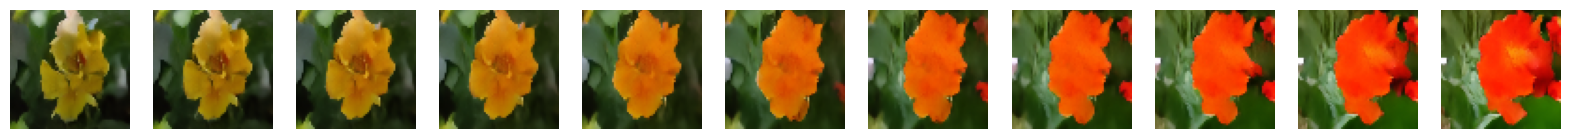

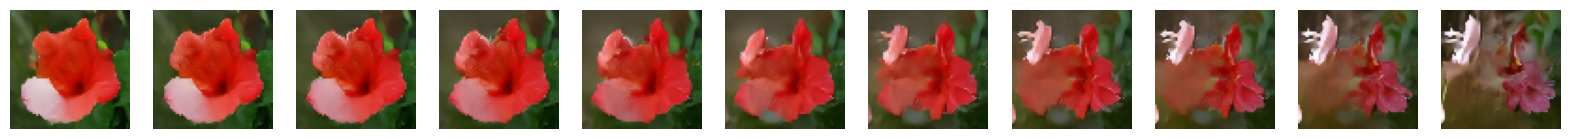

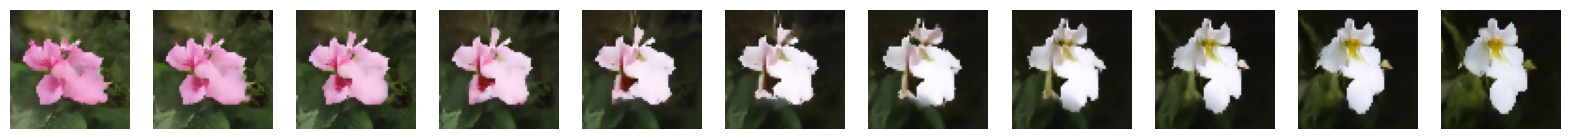

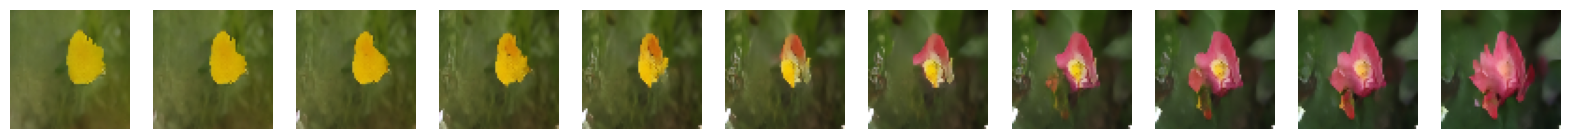

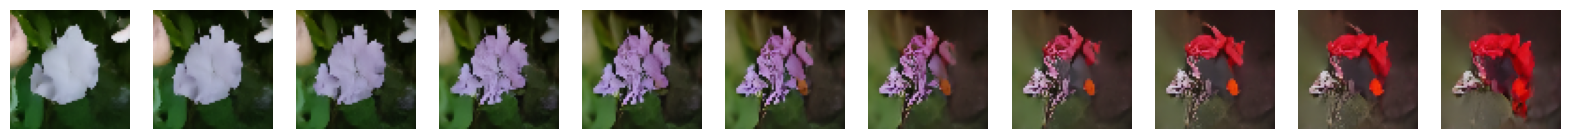

In [34]:
tf.random.set_seed(150)

def spherical_interpolation(a, b, t):
    t = tf.cast(t, tf.float32)
    return tf.sin(t * math.pi / 2) * a + tf.cos(t * math.pi / 2) * b

for i in range(5):
    a = tf.random.normal(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    b = tf.random.normal(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    initial_noise = tf.stack(
        [spherical_interpolation(a, b, t) for t in np.arange(0, 1.1, 0.1)]
    )

    generated_images = ddm.generate(
        num_images=11, diffusion_steps=20, initial_noise=initial_noise
    ).numpy()

    display(generated_images, n=11)


In [37]:
import shutil

shutil.make_archive("/kaggle/working/ddm_folders", 'zip', "/kaggle/working")

print("✅ Zipped successfully: /kaggle/working/ddm_folders.zip")

✅ Zipped successfully: /kaggle/working/ddm_folders.zip


In [38]:
pip install torch-fidelity


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.2 MB/s eta 0:00:0000:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.

In [47]:
import os, glob, shutil
from PIL import Image
import torch_fidelity

real_src = '/kaggle/input/phool-fool/flower_data/flower_data'   
gen_src  = '/kaggle/working/output'                
real_clean = '/kaggle/working/real_clean_299'
gen_clean  = '/kaggle/working/gen_clean_299'
TARGET_SIZE = (299, 299)   

os.makedirs(real_clean, exist_ok=True)
os.makedirs(gen_clean, exist_ok=True)

def clean_and_resize(src_root, dst_root, max_images=None):
    count, bad = 0, 0
    for path in glob.glob(f'{src_root}/**/*.*', recursive=True):
        if not path.lower().endswith(('.jpg', '.jpeg', '.png')): 
            continue
        if max_images is not None and count >= max_images:
            break
        try:
            with Image.open(path) as img:
                # force RGB and consistent size
                img = img.convert('RGB')
                img = img.resize(TARGET_SIZE, Image.LANCZOS)
                dst_path = os.path.join(dst_root, f"img_{count:06d}.jpg")
                img.save(dst_path, format='JPEG', quality=95)
                count += 1
        except Exception as e:
            bad += 1
    return count, bad

print("Cleaning real images...")
r_count, r_bad = clean_and_resize(real_src, real_clean)
print(f"Real: saved {r_count} images, skipped {r_bad} bad files -> {real_clean}")

print("Cleaning generated images...")
g_count, g_bad = clean_and_resize(gen_src, gen_clean)
print(f"Gen:  saved {g_count} images, skipped {g_bad} bad files -> {gen_clean}")

if r_count == 0:
    raise RuntimeError("No real images found after cleaning. Check real_src path.")
if g_count == 0:
    raise RuntimeError("No generated images found after cleaning. Check gen_src path.")

# FID
print("Computing FID (this may take a while)...")
metrics = torch_fidelity.calculate_metrics(
    input1=real_clean,
    input2=gen_clean,
    cuda=True,           
    fid=True,
    verbose=True,
    batch_size=8,        
    save_cpu_ram=True    
)

print(f"\n✅ FID: {metrics['frechet_inception_distance']:.4f}")


Cleaning real images...
Real: saved 8189 images, skipped 0 bad files -> /kaggle/working/real_clean_299
Cleaning generated images...
Gen:  saved 7052 images, skipped 0 bad files -> /kaggle/working/gen_clean_299
Computing FID (this may take a while)...


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/kaggle/working/real_clean_299" with extensions png,jpg,jpeg
Found 8189 samples, some are lossy-compressed - this may affect metrics
Processing samples                                                           
Extracting statistics from input 2
Looking for samples non-recursivelty in "/kaggle/working/gen_clean_299" with extensions png,jpg,jpeg
Found 7052 samples, some are lossy-compressed - this may affect metrics
Processing samples                                                           



✅ FID: 6.5521


Frechet Inception Distance: 6.552093245718709
